# **Machine Learning Lab 4EII - IA course**

## 1- **Introduction**

This lab aim at using **auto encoders** for diffrent applications such as image compression and image de-noising. The auto-encoder can be based on neural networks with dense layers or convolutional neural networks:  

In this lab you will learn to:
* Build you own auto-encoder based on NN and CNN.
* Apply the auto-encoder for image denoising and compression.
* Latent space manipulation (with GANs)


## 2- **Module importation**
Import some useful and common python modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import progressbar
import time

In [ ]:
import tensorflow as tf


tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1467524372280090519,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3499819008
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6785141387803027448
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

## 3- **Download and study the the MNIST dataset**



### 3.a - Download the MNIST dataset

MNIST dataset contains 70000 images of handwritten digits from 0 to 9. The dataset contains images of size 28x28 pixels and the corresponding labels

In [ ]:
mnist = fetch_openml('mnist_784') #You can also use and test mnist_784 or Fashion-MNIST dataset  

### 3.b - Create a class structure to save and analyse the dataset

In [ ]:
def computeentropy(image):
  lensig=image.size
  symset=list(set(image))
  numsym=len(symset)
  propab=[np.size(image[image==i])/(1.0*lensig) for i in symset]
  ent=np.sum([p*np.log2(1.0/p) for p in propab])
  return ent;

class Digit:
  def __init__(self, data, target):
    self.width      = int(np.sqrt((len(data))))
    self.target     = target;
    self.image      = data;
    
    self.features   = {
                        'var'        :0.0, 'std'        :0.0,
                        'mean'       :0.0, 'entropy'    :0.0,
                      }
    self.computeFeatures()
    
  def computeFeatures(self):
    self.features['var'] = round(np.var(self.image),2)
    self.features['std'] = round(np.std(self.image),2)
    self.features['mean'] = round(np.mean(self.image),2)
    self.features['entropy'] = round(computeentropy(self.image),2)

  def print(self):
    print("Digit target: " + str(self.target))
    print("Digit target size: "+ str(self.width)  + "x" +str(self.width) + 
          '| mean : ' + str(self.features['mean']) +
          '| var : ' + str(self.features['var']) + 
          '| std :' + str(self.features['std']) + 
          '| entropy :' + str(self.features['entropy']))
    print("Digit image:")
    plt.figure()
    plt.gray()
    plt.matshow(self.image.reshape(self.width, self.width)) 
    plt.savefig(str(self.target)+'.png', bbox_inches='tight')
    plt.show() 
  def getWidth(self):
    return self.width;


class Dataset:    
  def __init__(self, data, size=0, nb_classes=10):  
    self.length = int((len(data['data'])))
    if size > 0 and size <  self.length:
      self.length = size;
    else:
      size = self.length;  

    self.targets  = data['target'][0:size]
    self.data = data['data'][0:size];
    self.digits       = [];
    self.nb_classes = nb_classes; 
    self.createDigits()
    self.X_train = []; 
    self.X_test = []; 
    self.y_train = []; 
    self.y_test = [];  
  
  def printInfo(self):
    from collections import Counter
    
    c = Counter(self.targets)
    info = "Dataset size " + str(self.length)
    key_value = {} 
    for i in sorted(c.keys()):
      key_value[i] = c[i];
     
    plt.bar(key_value.keys(), key_value.values());
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of MNIST dataset labels')
    ax = plt.axes()        
    ax.grid(which='major', axis='y')
    plt.show()
    return info
  
  def createDigits(self):
    bar = progressbar.ProgressBar(maxval=self.length).start()
    for i in range(self.length):
        self.digits.append(Digit(self.data[i], self.targets[i]))
        bar.update(i+1);

  def separate_train_test(self, test_size_ratio):
    from sklearn.model_selection import train_test_split 
    import keras

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.targets, test_size=test_size_ratio)
    # data normalization   
    self.X_train = self.X_train.astype('float32')/255;
    self.X_test  = self.X_test.astype('float32')/255;

    
    print('Size of training set : ' + str(len(self.y_train)) + ' / ' + str(len(self.data)));
    print('Size of testing set : ' + str(len(self.y_test))+ ' / ' + str(len(self.data)));
    self.X_train  = self.X_train.reshape(len(self.X_train), self.digits[0].getWidth()*self.digits[0].getWidth())  # reshape input from (28,28) to 784
    self.X_test   = self.X_test.reshape(len(self.X_test), self.digits[0].width*self.digits[0].width)
    
   
    self.Y_train = keras.utils.to_categorical(self.y_train, self.nb_classes)
    self.Y_test = keras.utils.to_categorical(self.y_test, self.nb_classes)
  
  def reshapeinImage(self):
    width = self.digits[0].width; 
    self.X_trainIm = self.X_train.reshape(self.X_train.shape[0], width, width, 1)
    self.X_testIm  = self.X_test.reshape(self.X_test.shape[0], width, width, 1)
    
  def adddNoise(self, intensity=1):
    self.X_trainIm_noisy = self.X_trainIm + intensity * np.random.normal(loc=0.0, scale=1.0, size=self.X_trainIm.shape) 
    self.X_testIm_noisy = self.X_testIm + intensity * np.random.normal(loc=0.0, scale=1.0, size=self.X_testIm.shape) 

    self.X_trainIm_noisy = np.clip(self.X_trainIm_noisy, 0., 1.)
    self.X_testIm_noisy = np.clip(self.X_testIm_noisy, 0., 1.)



  def display_train_test(self):
    from collections import Counter

    test = Counter(self.y_test)
    train = Counter(self.y_train)
    info = "Dataset size " + str(self.length) 
    
    key_value_train = {};
    key_value_test = {};
    
    for i in sorted(test.keys()):
      key_value_test[i] = test[i];
    for i in sorted(train.keys()):
      key_value_train[i] = train[i];

    p1 = plt.bar(key_value_train.keys(), key_value_train.values(), width=0.5);
    p2 = plt.bar( key_value_test.keys(), key_value_test.values(), width=0.5, bottom=list(key_value_train.values()) ); 
    
    plt.legend((p1[0], p2[0]), ('Training set', 'Test set'), loc='lower left')
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of training and testing sets')
    ax = plt.axes()        
    ax.grid(which='major', axis='y')
    plt.show();    

### 3.b - Load the MNIST dataset in Dataset class and analyse it: 
1.   Load the dataset in Dataset class 

*samples* is the number of considered samples (sub-set) over 700000 of MNIST dataset, it enables faster training and testing



In [ ]:
samples = 0; # All pictures 
training_set  = Dataset(mnist, samples) 

2.   Display some digist with corresponding features  

Digit target: 5
Digit target size: 28x28| mean : 35.11| var : 6343.94| std :79.65| entropy :1.83
Digit image:


<Figure size 432x288 with 0 Axes>

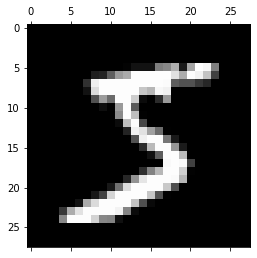

In [ ]:
samples_to_diplay = 1;
for i in range(samples_to_diplay):
  training_set.digits[i].print()

3.   Display digits repartitions with *printInfo* function of *Dataset* class

*   Is the dataset well balanced ?





In [ ]:
training_set.printInfo()

<ipython-input-4-6e5e4f8cbc6c>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


'Dataset size 70000'

## 4 - **Dataset preparation**


> The MNIST dataset is split to training and testing sets with the corresponding labels



### 4.a - Split the the MNIST dataset in training and testing sets 

*   Use *separate_train_test* function with a test set split ratio as parameter 
*   The test and train sets will be loaded in X_train and X_test lists and the corresponding labels in y_train and y_test lists. 




In [ ]:
test_ratio = 0.2;
training_set.separate_train_test(test_ratio)

Size of training set : 56000 / 70000
Size of testing set : 14000 / 70000


### 4.b - Display the repartition of the digits 

*   Use  *display_train_test* function to illustrate the digits' repartition 
*   Check whether the repartition ratio is correct 



<ipython-input-4-6e5e4f8cbc6c>:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


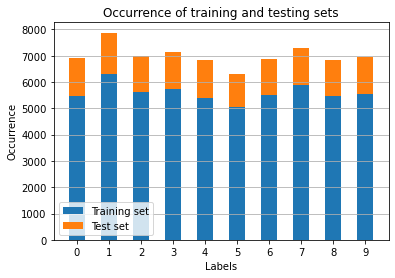

In [ ]:
training_set.display_train_test()

## 5 - **Build an auto-encoder with dense layers**


### 5.a - Build an auto-encoder with one dense layer


> Import keras module 

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

> In this section you will 

1) bluid an auto-encoder with one dense layer 

2) Train the auto-encodeur 

In [ ]:
original_dim = 784
latent_dim = 32

epochs=80
batch_size=256


input_img = Input(shape=(original_dim,))

encoder_layer = Dense(latent_dim, activation='relu');
encoded = encoder_layer(input_img)

decoder_layer = Dense(original_dim, activation='sigmoid') 
decoded = decoder_layer(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # you can also use MSE loss function 

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(latent_dim,))
decoder = Model(encoded_input, decoder_layer(encoded_input))


autoencoder.summary()

logsNN1 = autoencoder.fit(training_set.X_train, training_set.X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_test, training_set.X_test))#TO DO train the model 


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
219/219 [==============================] - 5s 5ms/step - loss: 0.3873 - val_loss: 0.1927
Epoch 2/80
219/219 [==============================] - 1s 3ms/step - loss: 0.1817 - val_loss: 0.1586
Epoch 3/80
219/219 [==============================] - 1s 2ms/step - loss: 0.1516 - val_loss: 0.1382
Epoch 4/80
219/219 [==============================] - 1s 2ms/step - loss: 0.1336 - val_

Epoch 75/80
219/219 [==============================] - 1s 2ms/step - loss: 0.0922 - val_loss: 0.0927
Epoch 76/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0922 - val_loss: 0.0927
Epoch 77/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0920 - val_loss: 0.0926
Epoch 78/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0921 - val_loss: 0.0926
Epoch 79/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0922 - val_loss: 0.0926
Epoch 80/80
219/219 [==============================] - 1s 2ms/step - loss: 0.0922 - val_loss: 0.0926


> Draw the evolution of the loss function during the training on training set and testing set 

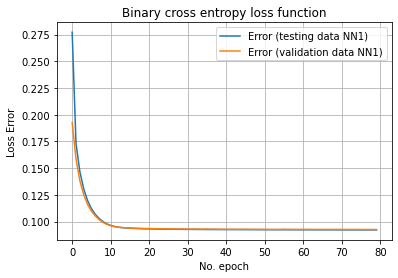

In [ ]:

plt.plot(logsNN1.history['loss'], label='Error (testing data NN1)')
plt.plot(logsNN1.history['val_loss'], label='Error (validation data NN1)')
plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

plt.grid()

> What is the number of trained parameters of this auto-encoder ?

> is it supervised or unsupervised learning ?

> What is the compression ratio enabled by this auto-encoder ? 

> Test the deep auto-encoder on testing set.

> Display the ten first images (original and decoded).





In [ ]:
encoded_imgs = encoder.predict(training_set.X_test)
#decoded_imgs = decoder.predict(encoded_imgs)
# you can also use 
decoded_imgs = autoencoder.predict(training_set.X_test); 

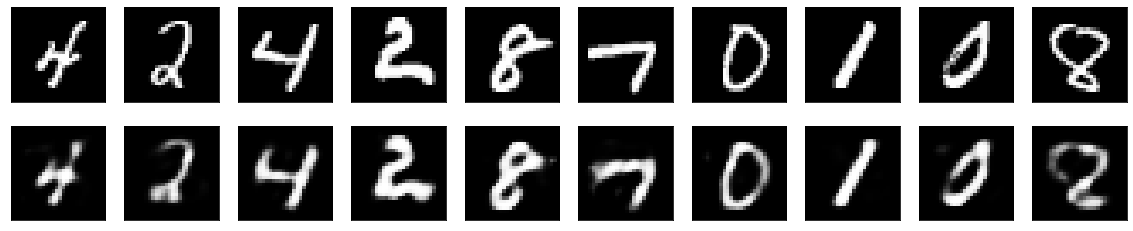

In [ ]:
def plotDigits(n, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(training_set.X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

plotDigits(10, decoded_imgs)

> you can also print the outputs of the encoder encoded_imgs (latent variables) of the ten first digits 

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(16, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 5.b - Build a deep auto-encoder with three dense layer

> Define a deep auto-encoder with three dense layers of size: 128, 64, 32.


In [ ]:
original_dim = 784
intermediate_dim0 = 128
intermediate_dim1 = 64
latent_dim = 32

# TO DO

input_img = Input(shape=(original_dim,))

encoder_layer0 = Dense(intermediate_dim0, activation='elu')
encoded0 = encoder_layer0(input_img)

encoder_layer1 = Dense(intermediate_dim1, activation='elu')
encoded1 = encoder_layer1(encoded0)

encoder_layer = Dense(latent_dim, activation='elu')
encoded = encoder_layer(encoded1)

decoder_layer1 = Dense(intermediate_dim1, activation='sigmoid') 
decoded1 = decoder_layer1(encoded)

decoder_layer0 = Dense(intermediate_dim0, activation='sigmoid') 
decoded0 = decoder_layer0(decoded1)

decoder_layer = Dense(original_dim, activation='sigmoid') 
decoded = decoder_layer(decoded0)

autoencoderNN3 = Model(input_img, decoded)
autoencoderNN3.compile(optimizer='adam', loss='binary_crossentropy') # you can also use MSE loss function 

autoencoder.summary()


logsNN3 = autoencoderNN3.fit(training_set.X_train, training_set.X_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_test, training_set.X_test))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
219/219 [==============================] - 1s 3ms/step - loss: 0.3565 - val_loss: 0.2640
Epoch 2/80
219/219 [==============================] - 1s 3ms/step - loss: 0.2620 - val_loss: 0.2487
Epoch 3/80
219/219 [==============================] - 1s 3ms/step - loss: 0.2454 - val_loss: 0.2389
Epoch 4/80
219/219 [==============================] - 1s 3ms/step - loss: 0.2335 - val_

Epoch 75/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0878 - val_loss: 0.0887
Epoch 76/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0875 - val_loss: 0.0884
Epoch 77/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0874 - val_loss: 0.0883
Epoch 78/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0875 - val_loss: 0.0884
Epoch 79/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0873 - val_loss: 0.0880
Epoch 80/80
219/219 [==============================] - 1s 3ms/step - loss: 0.0870 - val_loss: 0.0878


> Draw the evolution of the loss function during the training on training set and testing set 

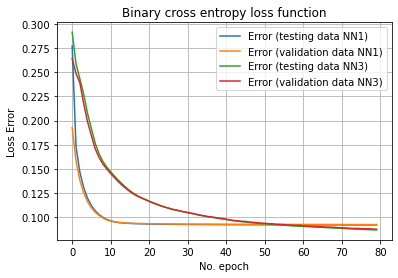

In [ ]:
plt.plot(logsNN1.history['loss'], label='Error (testing data NN1)')
plt.plot(logsNN1.history['val_loss'], label='Error (validation data NN1)')
plt.plot(logsNN3.history['loss'], label='Error (testing data NN3)')
plt.plot(logsNN3.history['val_loss'], label='Error (validation data NN3)')
plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()


> What is the number of trained parameters of this auto-encoder.

> What is the compression ration enabled by this auto-encoder. 

> Test the deep auto-encoder on testing set 

> Display the ten first image (original and decoded).

 

 

> - trained parameters: 50,992
> - compression ratio: original_dim / latent_dim = 24.5

In [ ]:
decoded_imgsNN3 = autoencoderNN3.predict(training_set.X_test)

> Print the ten first images in testing set with the decoded onces.

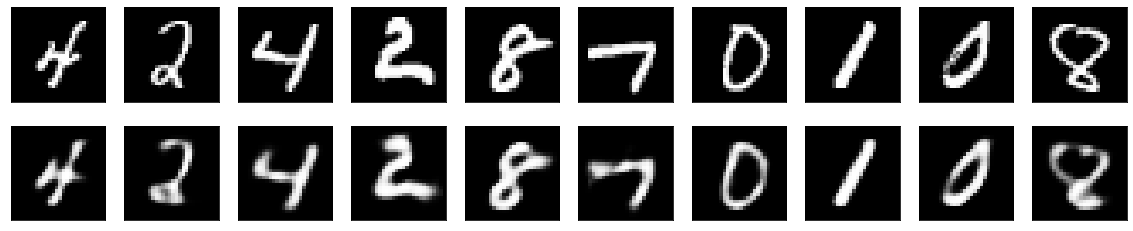

In [ ]:
plotDigits(10, decoded_imgsNN3)

### 5.c - Build a deep auto-encoder with only conv layers

> Define a deep auto-encoder with two conv layers both composed of 32 features and kernel of size (3,3) followed by MaxPooling2D((2, 2), padding='same') (/2) for encoder and UpSampling2D((2, 2)) (*2) for the decoder.  Add last layer with 1 feature, (3,3) kernel and a sigmoid activation function.  

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

training_set.reshapeinImage()

# TO DO

input_img = Input(shape=(28, 28, 1))

autoencoderConv = Sequential()
autoencoderConv.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same', input_shape=(28,28,1)))
autoencoderConv.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConv.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConv.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConv.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same'))
autoencoderConv.add(UpSampling2D((2, 2)))
autoencoderConv.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConv.add(UpSampling2D((2, 2)))
autoencoderConv.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoderConv.compile(optimizer='adam', loss='binary_crossentropy')

autoencoderConv.summary()


logsConv = autoencoderConv.fit(training_set.X_trainIm, training_set.X_trainIm,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_testIm, training_set.X_testIm))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9

> Print the evolution of the loss function during the training on training set and testing set 

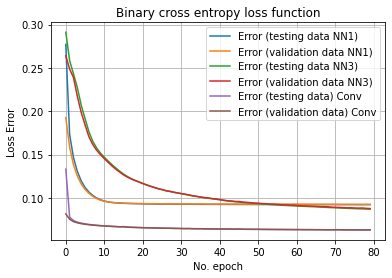

In [ ]:
plt.plot(logsNN1.history['loss'], label='Error (testing data NN1)')
plt.plot(logsNN1.history['val_loss'], label='Error (validation data NN1)')
plt.plot(logsNN3.history['loss'], label='Error (testing data NN3)')
plt.plot(logsNN3.history['val_loss'], label='Error (validation data NN3)')
plt.plot(logsConv.history['loss'], label='Error (testing data) Conv')
plt.plot(logsConv.history['val_loss'], label='Error (validation data) Conv')
plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()

> Test the Conv auto-encoder on testing set.


In [ ]:
decoded_imgsConv = autoencoderConv.predict(training_set.X_testIm)

> Print the ten first images in testing set with the decoded onces.

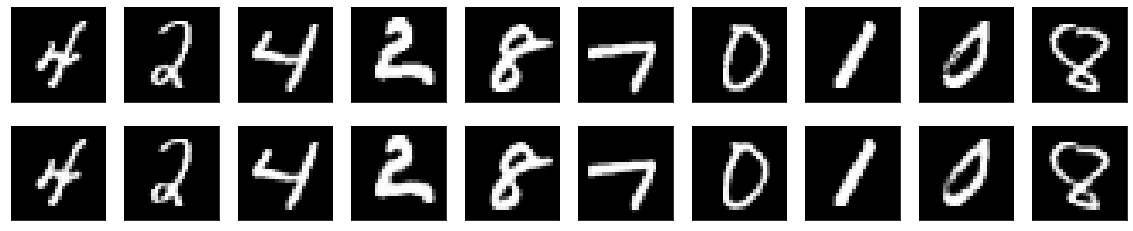

In [ ]:
plotDigits(10, decoded_imgsConv)

> What do you think about the quality of the reconstructed images, compare with those of previous auto-encoders 

> *The autoencoder with convolutional layers clearly presents visually better performance. It is almost imperceptible the difference with this approach in this case.*

## 6- Application to image denoising

> Add noise to the testing sets and try to denoise with the prevous auto-encoder




In [ ]:
Noiseintensity = 0.5;
training_set.adddNoise(Noiseintensity);
decoded_imgsNoise = autoencoderConv.predict(training_set.X_testIm_noisy)


> Illustrate the 10 images before and after denoising process

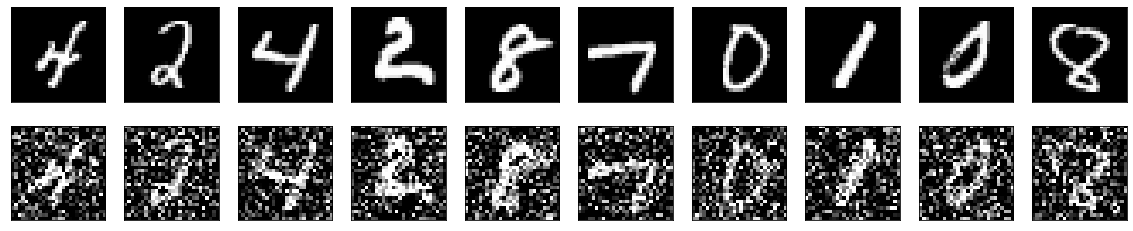

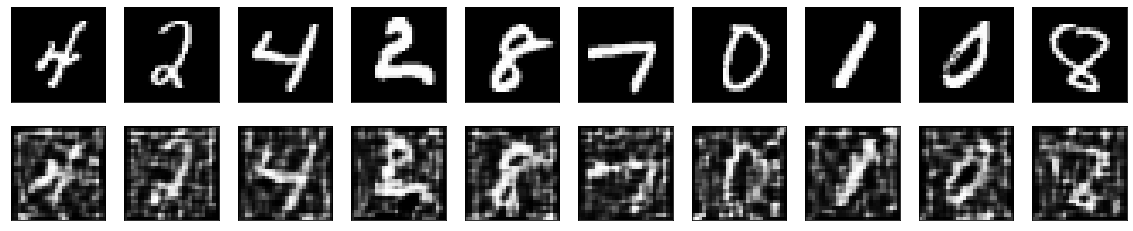

In [ ]:
plotDigits(10, training_set.X_testIm_noisy)
plotDigits(10, decoded_imgsNoise)

> Now, you can define and train the last auto-encoder to perform denoising

In [ ]:

# TO DO
# Define the conv auto-encoder model and train it for denoising

input_img = Input(shape=(28, 28, 1))

autoencoderConvDenoise = Sequential()
autoencoderConvDenoise.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same', input_shape=(28,28,1)))
autoencoderConvDenoise.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConvDenoise.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConvDenoise.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
autoencoderConvDenoise.add(Conv2D(32, kernel_size=(3, 3), activation='elu', padding='same'))
autoencoderConvDenoise.add(UpSampling2D((2, 2)))
autoencoderConvDenoise.add(Conv2D(32, (3, 3), activation='elu', padding='same'))
autoencoderConvDenoise.add(UpSampling2D((2, 2)))
autoencoderConvDenoise.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoderConvDenoise.compile(optimizer='adam', loss='binary_crossentropy')

autoencoderConvDenoise.summary()


logsconvDen = autoencoderConvDenoise.fit(training_set.X_trainIm_noisy, training_set.X_trainIm,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(training_set.X_testIm_noisy, training_set.X_testIm))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)       

> Denoise the testing set 



In [ ]:
decoded_imgsConvNoise = autoencoderConvDenoise.predict(training_set.X_testIm_noisy)

> Illustrate the 10 images before and after denoising process

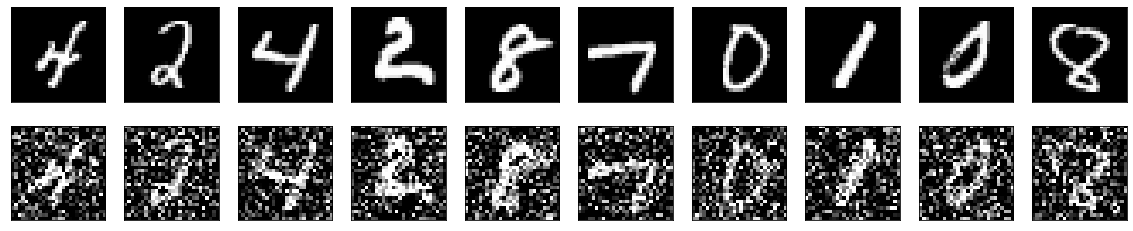

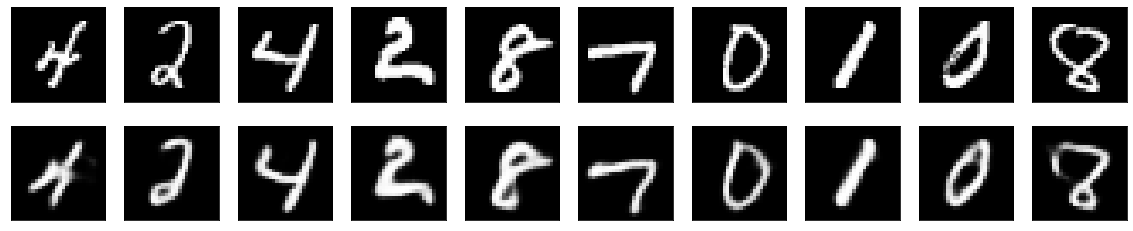

In [ ]:
plotDigits(10, training_set.X_testIm_noisy)
plotDigits(10, decoded_imgsConvNoise)

In [ ]:
plt.plot(logsConv.history['loss'], label='MAE (testing data) Conv')
plt.plot(logsConv.history['val_loss'], label='MAE (validation data) Conv')
plt.plot(logsconvDen.history['loss'], label='MAE (testing data) Conv denoise')
plt.plot(logsconvDen.history['val_loss'], label='MAE (validation data) Conv denoise')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

plt.grid()
plt.show()

## 7- Generative Adversarial Networks



> In this section you will use StyleGan2 to experiment with latent space manipulation

### 7.a- Clone stylegan2 repo and download dataset

> First, we need to fix the version of tensorflow to 1 since styleGAN2 is not compatible with TF >= 2.

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


> Then we clone the repository of the StyleGAN2.

> *Note that this is not the official repo (located at https://github.com/NVlabs/stylegan2).*

In [4]:
%rm -rf /conten/stylegan2/
!git clone https://github.com/woctezuma/stylegan2.git
%cd /content/stylegan2/
!git checkout tiled-projector
# Check cpu and gpu
!nvcc test_nvcc.cu -o test_nvcc -run

fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
Branch 'tiled-projector' set up to track remote branch 'tiled-projector' from 'origin'.
Switched to a new branch 'tiled-projector'
CPU says hello.
GPU says hello.


> Import necessary modules and load pretrained StyleGAN2 generator on [FFHQ dataset](https://github.com/NVlabs/ffhq-dataset)

In [5]:
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
from math import ceil
import PIL.Image
from PIL import Image, ImageDraw
import pretrained_networks

network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"
## Gs is the pretrained generator
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
## Gs_kwargs is 
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


> Download a dataset of images and their corresponding projected variables.

In [6]:
%cd /content
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-3EQOUVFkT7eDOzZH6kVDyDVkN0gs4XH' -O /content/generated_images.tar.gz
!tar -xf /content/generated_images.tar.gz
%mv /content/generated_images_no_tiled /content/generated_images
%rm /content/generated_images.tar.gz

/content
--2021-04-25 12:13:01--  https://docs.google.com/uc?export=download&id=1-3EQOUVFkT7eDOzZH6kVDyDVkN0gs4XH
Resolving docs.google.com (docs.google.com)... 172.217.13.238, 2607:f8b0:4004:809::200e
Connecting to docs.google.com (docs.google.com)|172.217.13.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g1qtgmaq0oaq71u2v5583b3ilq98u56v/1619352750000/10018676700585892593/*/1-3EQOUVFkT7eDOzZH6kVDyDVkN0gs4XH?e=download [following]
--2021-04-25 12:13:04--  https://doc-0o-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/g1qtgmaq0oaq71u2v5583b3ilq98u56v/1619352750000/10018676700585892593/*/1-3EQOUVFkT7eDOzZH6kVDyDVkN0gs4XH?e=download
Resolving doc-0o-c0-docs.googleusercontent.com (doc-0o-c0-docs.googleusercontent.com)... 142.251.33.193, 2607:f8b0:4004:837::2001
Connecting to doc-0o-c0-docs.googleusercontent.com (doc-0o-c0-d

> Create a function to variables from the .npy files and a function to display various images in a grid.

In [7]:
def load_latent_vector(file):
  w = np.load(file)
  w = np.expand_dims(w, axis=0)
  return w
            
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

### 7.b - Generation from drawn latent space

> In this section we use the generator to create images from random noise.

> Numpy is used to generate a random vector z. Then this latent variable is fed to the styleGAN2 generator using `Gs.run`.

In [9]:
seed = 2020# TO DO chose a seed (example 2021)
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:])

im = Gs.run(z, None, **Gs_kwargs)[0]
im = PIL.Image.fromarray(im)
display(im)

s_stylegan.png

> StyleGAN2 uses linear projection to feed each of its generator layers with a specific latent variable (see image above). The first layers are responsible of the global look of the output image, while the last ones are responsible of finner details.

> For the rest of this TP, we will use a vector containing every projection meaning there will be two differences in the code :

  - The latent variable z of shape 1x512 will be replaced by the projected variable w of shape 1x18x512 (18 being the number of layer in the generator).

  - We will skip the projection part of the generator and directly feed the w's. This meen we will no longer use `Gs.run` but `Gs.components.synthesis.run` instead.

> The projected variables were retrieved using gradient descent on real images and are located in the **/content/generated_images** folder. The **optional** section 7.e show you the process of image projection with StyleGAN2.

### 7.c - Interpolation

> The interpolation between $w_1$ and $w_2$ is done using the following formula:

$$\hat{w} = w_1 u + w_2 (1 - u)$$

In [10]:
w1 = load_latent_vector('/content/generated_images/Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched_01.npy')
w2 = load_latent_vector('/content/generated_images/emmanuel-macron_01.npy')

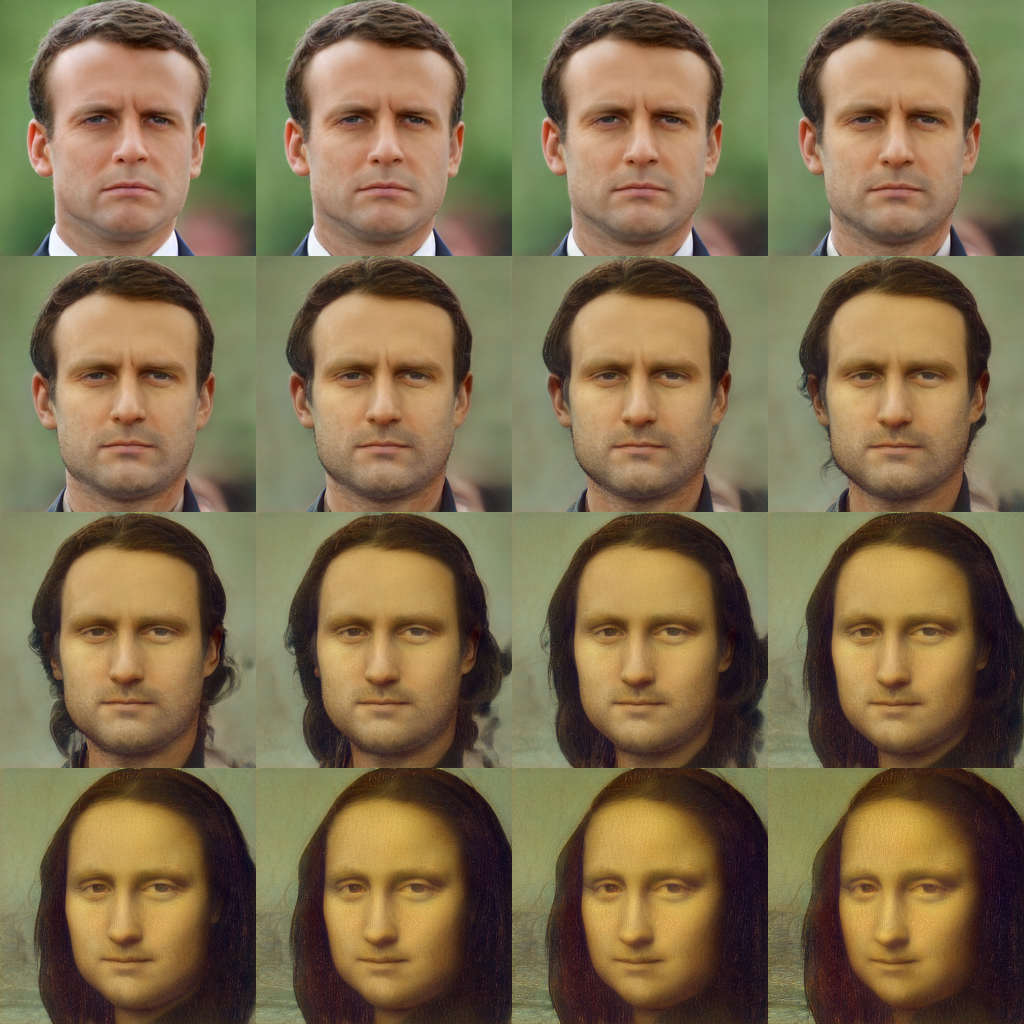

In [13]:
steps = 16
images = []
for u in np.linspace(0,1,steps):
  w = w1*u + w2*(1-u) ## TO DO
  im = Gs.components.synthesis.run(w, **Gs_kwargs)[0]
  im = PIL.Image.fromarray(im)
  images.append(im)
display(createImageGrid(images, rows=4))

### 7.d - Style transfert

> The style transfert is done by combining the 7 first layers inputs from our style reference and the rest (11 layers) from the finer details reference.

In [14]:
finner = load_latent_vector('/content/generated_images/emmanuel-macron_01.npy')
style = load_latent_vector('/content/generated_images/Venus_botticelli_detail_01.npy')

In [16]:
w = np.zeros(w1.shape)
w[:,:7] = style[:,:7]# TO DO
w[:,7:] = finner[:,7:]# TO DO
im1 = Gs.components.synthesis.run(finner, **Gs_kwargs)[0]
im1 = PIL.Image.fromarray(im1)
im2 = Gs.components.synthesis.run(style, **Gs_kwargs)[0]
im2 = PIL.Image.fromarray(im2)
im = Gs.components.synthesis.run(w, **Gs_kwargs)[0]
im = PIL.Image.fromarray(im)
display(createImageGrid([im1,im,im2], scale=0.5, rows=1))

### 7.e - Project images into latent space **(OPTIONAL)**

> You can skip this step if you don't have anough time.

> Here we use two python files from the styleGAN2 folder which:
 - **align_images.py**: Crop the image for it to have the same size as our network input. It also realign it to look similar to what our network could generate.
 - **project_images.py**: Compute the latent variable corresponding to our realigned image. The latent variable is estimated using gradient descent over 1000 iterations.


In [ ]:
!mkdir /content/raw_images

> You can upload images (Folder menu on the right hand of your screen), store them in the **/content/raw_images** folder and run the next cell to create a projection of your custom face. The result will be added to the **/content/generated_images** folder downloaded earlier.

In [ ]:
!python /content/stylegan2/align_images.py /content/raw_images/ /content/aligned_images/
!python /content/stylegan2/project_images.py /content/aligned_images/ /content/generated_images/ --no-tiled